Epoch 0, Loss: 4.033656e+03
Epoch 200, Loss: 5.104052e+02
Epoch 400, Loss: 1.135381e+02
Epoch 600, Loss: 3.367720e+01
Epoch 800, Loss: 1.217033e+01
Epoch 1000, Loss: 5.208956e+00
Epoch 1200, Loss: 2.593282e+00
Epoch 1400, Loss: 1.402829e+00
Epoch 1600, Loss: 8.159338e-01
Epoch 1800, Loss: 4.949746e-01


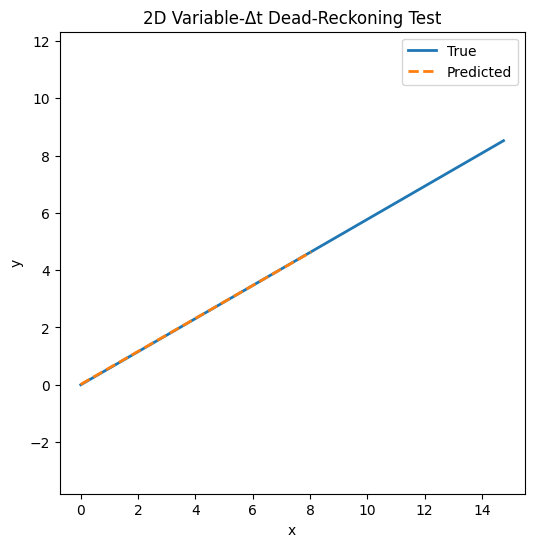

In [1]:
import torch
import math
import random

def generate_2d_trajectory_variable_dt(
    x0=0.0,
    y0=0.0,
    v=2.0,
    theta=math.pi / 6,
    dt_min=0.05,
    dt_max=0.3,
    T=100
):
    xs, ys, dts = [x0], [y0], []

    for _ in range(T):
        dt = random.uniform(dt_min, dt_max)
        dts.append(dt)

        xs.append(xs[-1] + v * math.cos(theta) * dt)
        ys.append(ys[-1] + v * math.sin(theta) * dt)

    return torch.tensor(xs), torch.tensor(ys), torch.tensor(dts)

def build_2d_training_pairs_variable_dt(xs, ys, dts, v, theta):
    X, Y = [], []

    for t in range(len(dts)):
        X.append([xs[t], ys[t], v, theta, dts[t]])
        Y.append([xs[t + 1], ys[t + 1]])

    return torch.tensor(X), torch.tensor(Y)


def generate_2d_trajectory(
    x0=0.0, y0=0.0,
    v=2.0,
    theta=math.pi / 6,  # 30 degrees
    dt=0.1,
    T=100
):
    xs, ys = [x0], [y0]

    for _ in range(T):
        xs.append(xs[-1] + v * math.cos(theta) * dt)
        ys.append(ys[-1] + v * math.sin(theta) * dt)

    return torch.tensor(xs), torch.tensor(ys)

def build_2d_training_pairs(xs, ys, v, theta, dt):
    X, Y = [], []

    for t in range(len(xs) - 1):
        X.append([xs[t], ys[t], v, theta, dt])
        Y.append([xs[t + 1], ys[t + 1]])

    return torch.tensor(X), torch.tensor(Y)

import torch.nn as nn

class TransitionNet2D(nn.Module):
    def __init__(self, width=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, 2)
        )

    def forward(self, x):
        return self.net(x)

def physics_residual_2d(X, Y_pred, v):
    x_t = X[:, 0]
    y_t = X[:, 1]
    theta = X[:, 3]
    dt = X[:, 4]

    x_phys = x_t + v * torch.cos(theta) * dt
    y_phys = y_t + v * torch.sin(theta) * dt

    return Y_pred[:, 0] - x_phys, Y_pred[:, 1] - y_phys

def loss_fn_2d(model, X, Y, v, lambda_phys=10.0):
    Y_pred = model(X)

    data_loss = torch.mean((Y_pred - Y)**2)

    rx, ry = physics_residual_2d(X, Y_pred, v)
    phys_loss = torch.mean(rx**2 + ry**2)

    return data_loss + lambda_phys * phys_loss

def train_2d(model, X, Y, v, epochs=2000, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()
        loss = loss_fn_2d(model, X, Y, v)
        loss.backward()
        opt.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

def rollout_2d(model, x0, y0, v, theta, dt, steps):
    xs, ys = [x0], [y0]
    x, y = x0, y0

    for _ in range(steps):
        inp = torch.tensor([[x, y, v, theta, dt]])
        out = model(inp)
        x, y = out[0, 0].item(), out[0, 1].item()
        xs.append(x)
        ys.append(y)

    return xs, ys


import math
import matplotlib.pyplot as plt

# Physics parameters
v = 2.0
theta = math.pi / 6    # 30 degrees
dt = 0.1
T = 100

xs, ys, dts = generate_2d_trajectory_variable_dt(
    x0=0.0,
    y0=0.0,
    v=v,
    theta=theta,
    dt_min=0.05,
    dt_max=0.3,
    T=T
)


X, Y = build_2d_training_pairs_variable_dt(xs, ys, dts, v, theta)

model = TransitionNet2D(width=64)

train_2d(
    model,
    X,
    Y,
    v=v,
    epochs=2000,
    lr=1e-3
)

x_pred, y_pred = rollout_2d(
    model,
    x0=0.0,
    y0=0.0,
    v=v,
    theta=theta,
    dt=dt,
    steps=50
)

plt.figure(figsize=(6, 6))
plt.plot(xs[:51], ys[:51], label="True", linewidth=2)
plt.plot(x_pred, y_pred, "--", label="Predicted", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis("equal")
plt.title("2D Variable-Δt Dead-Reckoning Test")
plt.show()

